# **14 - OBSERVED DAMAGE GRADE ANALYSIS AND PREPROCESSING**

**IRDR0012 MSc Independent Research Project**

*   Candidate number: NWHL6
*   Institution: UCL IRDR
*   Supervisor: Dr. Roberto Gentile
*   Date: 01/09/2025
*   Version: v1.0

**Description:**

This script analyzes observed damage grades from the Morocco earthquake,
converts them to HAZUS damage states, and creates visualizations for
comparison with analytical fragility predictions.

**INPUT FILES:**

*   NWHL6-CSV-P01_Exposure model_Master_filtered for analysis.csv
*   exposure_gmpe_AkkarEtAlRjb2014.csv
*   exposure_gmpe_ChiouYoungs2014.csv

**OUTPUT FILES:**

*   observed_damage_processed.csvv
*   observed_damage_with_AkkarEtAlRjb2014.csv
*   observed_damage_with_ChiouYoungs2014.csv
*   observed_damage_summary_statistics.csv

# 0. ENVIRONMENT SETUP

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("=" * 70)
print("SCRIPT 2: OBSERVED DAMAGE GRADE ANALYSIS")
print("=" * 70)
print("Environment setup complete")

SCRIPT 2: OBSERVED DAMAGE GRADE ANALYSIS
Environment setup complete


# 1. DATA PATHS AND CONFIGURATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

INPUT_FOLDER = '/content/drive/MyDrive/IRDR0012_Research Project/00 INPUT/'
OUTPUT_FOLDER = '/content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/'

print(f"Input folder: {INPUT_FOLDER}")
print(f"Output folder: {OUTPUT_FOLDER}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Input folder: /content/drive/MyDrive/IRDR0012_Research Project/00 INPUT/
Output folder: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/


# 2. LOAD EXPOSURE DATA WITH OBSERVED DAMAGE

In [ ]:
def load_exposure_with_damage():
    """Load exposure data containing observed damage grades."""

    filename = f'{INPUT_FOLDER}NWHL6-CSV-P01_Exposure model_Master_filtered for analysis.csv'

    try:
        df = pd.read_csv(filename)
        print(f"✓ Loaded {len(df):,} building records")

        # Check for required columns
        required_cols = ['ID', 'building_class', 'DG', 'Latitute', 'Longitude']
        missing_cols = [col for col in required_cols if col not in df.columns]

        if missing_cols:
            print(f"⚠ Missing columns: {missing_cols}")
            return None

        return df

    except FileNotFoundError:
        print(f"✗ File not found: {filename}")
        return None

print("\n" + "=" * 70)
print("LOADING EXPOSURE DATA WITH OBSERVED DAMAGE")
print("=" * 70)

exposure_df = load_exposure_with_damage()

if exposure_df is None:
    print("✗ Could not load exposure data")
    exit()


LOADING EXPOSURE DATA WITH OBSERVED DAMAGE
✓ Loaded 2,508 building records


# 3. ANALYZE OBSERVED DAMAGE DISTRIBUTION

In [ ]:
print("\n" + "=" * 70)
print("OBSERVED DAMAGE GRADE ANALYSIS")
print("=" * 70)

# Overall damage grade distribution
print("\nOverall Damage Grade Distribution:")
print("-" * 40)
dg_dist = exposure_df['DG'].value_counts().sort_index()
for dg, count in dg_dist.items():
    percentage = (count / len(exposure_df)) * 100
    print(f"  {dg}: {count:,} buildings ({percentage:.1f}%)")

# Damage grade distribution by building class
print("\nDamage Grade Distribution by Building Class:")
print("-" * 40)

for building_class in exposure_df['building_class'].unique():
    class_data = exposure_df[exposure_df['building_class'] == building_class]
    print(f"\n{building_class} (n={len(class_data):,}):")

    dg_dist = class_data['DG'].value_counts().sort_index()
    for dg, count in dg_dist.items():
        percentage = (count / len(class_data)) * 100
        print(f"  {dg}: {count:,} ({percentage:.1f}%)")


OBSERVED DAMAGE GRADE ANALYSIS

Overall Damage Grade Distribution:
----------------------------------------
  DG0: 2,231 buildings (89.0%)
  DG1: 189 buildings (7.5%)
  DG2: 10 buildings (0.4%)
  DG3: 46 buildings (1.8%)
  DG4: 10 buildings (0.4%)
  DG5: 22 buildings (0.9%)

Damage Grade Distribution by Building Class:
----------------------------------------

MCF_H2 (n=1,011):
  DG0: 899 (88.9%)
  DG1: 102 (10.1%)
  DG2: 5 (0.5%)
  DG3: 2 (0.2%)
  DG4: 2 (0.2%)
  DG5: 1 (0.1%)

EU_H1 (n=1,346):
  DG0: 1,310 (97.3%)
  DG2: 2 (0.1%)
  DG3: 26 (1.9%)
  DG4: 2 (0.1%)
  DG5: 6 (0.4%)

MCF_H3 (n=151):
  DG0: 22 (14.6%)
  DG1: 87 (57.6%)
  DG2: 3 (2.0%)
  DG3: 18 (11.9%)
  DG4: 6 (4.0%)
  DG5: 15 (9.9%)


# 4. CONVERT DAMAGE GRADES TO DAMAGE STATES

In [ ]:
print("\n" + "=" * 70)
print("DAMAGE STATES ANALYSIS")
print("=" * 70)

# The DG column already contains HAZUS damage states, not EMS-98 grades
exposure_df['observed_ds'] = exposure_df['DG']

print("\nDamage State Distribution:")
print("-" * 40)
ds_dist = exposure_df['observed_ds'].value_counts()
damage_state_order = ['None', 'Slight', 'Moderate', 'Extensive', 'Complete']

for ds in damage_state_order:
    if ds in ds_dist.index:
        count = ds_dist[ds]
        percentage = (count / len(exposure_df)) * 100
        print(f"  {ds}: {count:,} buildings ({percentage:.1f}%)")

print("\nNote: The data already contains HAZUS damage states, not EMS-98 damage grades.")


DAMAGE STATES ANALYSIS

Damage State Distribution:
----------------------------------------
  None: 2,231 buildings (89.0%)
  Slight: 189 buildings (7.5%)
  Moderate: 10 buildings (0.4%)
  Extensive: 46 buildings (1.8%)
  Complete: 32 buildings (1.3%)

Note: The data already contains HAZUS damage states, not EMS-98 damage grades.


# 5. VISUALISATION

In [ ]:
def load_gmpe_for_observed(gmpe_model):
    """Load GMPE data to associate ground motion with observed damage."""

    filename = f'{INPUT_FOLDER}exposure_gmpe_{gmpe_model}.csv'

    try:
        df = pd.read_csv(filename)
        print(f"  ✓ Loaded {len(df):,} GMPE records for {gmpe_model}")
        return df
    except FileNotFoundError:
        print(f"  ✗ File not found: {filename}")
        return None

# Load GMPE data and merge with observed damage
gmpe_models = ['AkkarEtAlRjb2014', 'ChiouYoungs2014']
observed_with_gmpe = {}

print("\n" + "=" * 70)
print("LOADING GMPE DATA FOR OBSERVED DAMAGE ANALYSIS")
print("=" * 70)

for gmpe_model in gmpe_models:
    print(f"\nProcessing {gmpe_model}:")

    gmpe_df = load_gmpe_for_observed(gmpe_model)
    if gmpe_df is None:
        continue

    # Merge with exposure data based on building ID and appropriate IMT
    merged_data = []

    # Define IMT for each building class
    imt_mapping = {
        'MCF_H2': 'SA(0.3)',
        'MCF_H3': 'SA(1.0)',
        'EU_H1': 'PGA'
    }

    for building_class, required_imt in imt_mapping.items():
        class_buildings = exposure_df[exposure_df['building_class'] == building_class]

        for _, building in class_buildings.iterrows():
            building_id = building['ID']  # Using uppercase ID

            # Find matching GMPE record
            gmpe_match = gmpe_df[
                (gmpe_df['id'] == building_id) &  # GMPE uses lowercase
                (gmpe_df['imt'] == required_imt)
            ]

            if len(gmpe_match) > 0:
                gmpe_record = gmpe_match.iloc[0]

                # Create merged record - fix column names
                merged_record = {
                    'id': building_id,
                    'building_class': building_class,
                    'DG': building['DG'],
                    'observed_ds': building['observed_ds'],
                    'latitude': building['Latitute'],  # Note the typo in your data
                    'longitude': building['Longitude'],
                    'imt': required_imt,
                    'imt_p5': gmpe_record['p5'],
                    'imt_p16': gmpe_record['p16'],
                    'imt_p50': gmpe_record['p50'],
                    'imt_p84': gmpe_record['p84'],
                    'imt_p95': gmpe_record['p95']
                }
                merged_data.append(merged_record)

    if merged_data:
        observed_with_gmpe[gmpe_model] = pd.DataFrame(merged_data)
        print(f"  ✓ Merged {len(merged_data):,} buildings with GMPE data")
    else:
        print(f"  WARNING: No buildings could be merged")


LOADING GMPE DATA FOR OBSERVED DAMAGE ANALYSIS

Processing AkkarEtAlRjb2014:
  ✓ Loaded 67,904 GMPE records for AkkarEtAlRjb2014
  ✓ Merged 2,508 buildings with GMPE data

Processing ChiouYoungs2014:
  ✓ Loaded 67,904 GMPE records for ChiouYoungs2014
  ✓ Merged 2,508 buildings with GMPE data


In [ ]:
def create_observed_violin_plots(observed_data, gmpe_model):
    """Create violin plots for observed damage states."""

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    building_classes = ['MCF_H2', 'MCF_H3', 'EU_H1']

    for idx, building_class in enumerate(building_classes):
        ax = axes[idx]
        class_data = observed_data[observed_data['building_class'] == building_class]

        if len(class_data) == 0:
            ax.text(0.5, 0.5, 'No Data', transform=ax.transAxes,
                   ha='center', va='center', fontsize=12, color='gray')
            ax.set_title(f'{building_class}\n(n=0)')
            continue

        # Prepare data for violin plot
        damage_states = ['None', 'Slight', 'Moderate', 'Extensive', 'Complete']
        violin_data = []
        positions = []
        colors = []

        color_map = {
            'None': '#E8E8E8',
            'Slight': '#8DB9CA',
            'Moderate': '#A8C4B8',
            'Extensive': '#C3CFA6',
            'Complete': '#C94B54'
        }

        for i, ds in enumerate(damage_states):
            ds_data = class_data[class_data['observed_ds'] == ds]['imt_p50'].values
            if len(ds_data) > 0:
                violin_data.append(ds_data)
                positions.append(i)
                colors.append(color_map[ds])

        if len(violin_data) > 0:
            parts = ax.violinplot(violin_data, positions=positions,
                                 widths=0.7, showmeans=True, showmedians=True)

            # Color the violins
            for pc, color in zip(parts['bodies'], colors):
                pc.set_facecolor(color)
                pc.set_alpha(0.7)

            # Make statistical markers black
            parts['cmeans'].set_color('black')
            parts['cmedians'].set_color('black')
            parts['cbars'].set_color('black')
            parts['cmaxes'].set_color('black')
            parts['cmins'].set_color('black')

            # Set y-axis limits based on data
            all_data = np.concatenate(violin_data)
            data_min = all_data.min()
            data_max = all_data.max()
            padding = (data_max - data_min) * 0.1
            ax.set_ylim(max(0, data_min - padding), data_max + padding)

        ax.set_xticks(range(len(damage_states)))
        ax.set_xticklabels(damage_states, rotation=45)
        ax.set_ylabel('Median IMT (p50) [g]')
        ax.set_title(f'{building_class}\n(n={len(class_data)})')
        ax.grid(True, alpha=0.3, axis='y')

    fig.suptitle(f'Observed Damage States - IMT Distribution\n{gmpe_model}',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

In [ ]:
def create_observed_percentile_plots(observed_data, gmpe_model):
    """Create damage state plots across percentiles for observed data."""

    fig, axes = plt.subplots(3, 3, figsize=(15, 12))

    building_classes = ['MCF_H2', 'MCF_H3', 'EU_H1']
    percentiles = ['p16', 'p50', 'p84']

    for class_idx, building_class in enumerate(building_classes):
        class_data = observed_data[observed_data['building_class'] == building_class]

        for perc_idx, percentile in enumerate(percentiles):
            ax = axes[class_idx, perc_idx]

            if len(class_data) == 0:
                ax.text(0.5, 0.5, 'No Data', transform=ax.transAxes,
                       ha='center', va='center', fontsize=12, color='gray')
                ax.set_title(f'{building_class} - {percentile.upper()}')
                continue

            imt_col = f'imt_{percentile}'

            # Plot observed damage states
            damage_states = ['None', 'Slight', 'Moderate', 'Extensive', 'Complete']
            colors = ['#E8E8E8', '#8DB9CA', '#A8C4B8', '#C3CFA6', '#C94B54']

            for ds, color in zip(damage_states, colors):
                ds_data = class_data[class_data['observed_ds'] == ds]
                if len(ds_data) > 0:
                    # Add jitter for visibility
                    y_pos = np.random.normal(damage_states.index(ds), 0.1, len(ds_data))
                    ax.scatter(ds_data[imt_col], y_pos,
                             alpha=0.5, s=20, c=color, label=ds)

            ax.set_ylim(-0.5, 4.5)
            ax.set_xlim(0, class_data[imt_col].max() * 1.1 if len(class_data) > 0 else 1)
            ax.set_yticks(range(5))
            ax.set_yticklabels(damage_states if perc_idx == 0 else [])
            ax.set_xlabel(f'IMT {percentile.upper()} (g)')
            if perc_idx == 0:
                ax.set_ylabel('Observed Damage State')
            ax.set_title(f'{building_class} - {percentile.upper()}')
            ax.grid(True, alpha=0.3)

            if class_idx == 0 and perc_idx == 2:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    fig.suptitle(f'Observed Damage States Across IMT Percentiles\n{gmpe_model}',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

In [ ]:
def create_statistical_summary(observed_data, gmpe_model):
    """Create statistical summary of observed damage vs IMT."""

    print(f"\n{gmpe_model} - Statistical Summary:")
    print("-" * 60)

    summary_stats = []

    for building_class in observed_data['building_class'].unique():
        class_data = observed_data[observed_data['building_class'] == building_class]

        for ds in ['None', 'Slight', 'Moderate', 'Extensive', 'Complete']:
            ds_data = class_data[class_data['observed_ds'] == ds]

            if len(ds_data) > 0:
                stats = {
                    'GMPE': gmpe_model,
                    'Building_Class': building_class,
                    'Damage_State': ds,
                    'Count': len(ds_data),
                    'Percentage': len(ds_data) / len(class_data) * 100,
                    'Mean_IMT_p50': ds_data['imt_p50'].mean(),
                    'Std_IMT_p50': ds_data['imt_p50'].std(),
                    'Min_IMT_p50': ds_data['imt_p50'].min(),
                    'Max_IMT_p50': ds_data['imt_p50'].max()
                }
                summary_stats.append(stats)

    summary_df = pd.DataFrame(summary_stats)

    # Display summary
    for building_class in summary_df['Building_Class'].unique():
        print(f"\n{building_class}:")
        class_summary = summary_df[summary_df['Building_Class'] == building_class]

        print(f"{'DS':<10} {'Count':<8} {'%':<8} {'Mean_IMT':<10} {'Std_IMT':<10}")
        print("-" * 50)

        for _, row in class_summary.iterrows():
            print(f"{row['Damage_State']:<10} {row['Count']:<8} "
                  f"{row['Percentage']:<8.1f} {row['Mean_IMT_p50']:<10.3f} "
                  f"{row['Std_IMT_p50']:<10.3f}")

    return summary_df


GENERATING VISUALIZATIONS FOR OBSERVED DAMAGE

Processing visualizations for AkkarEtAlRjb2014:
  Creating violin plots...


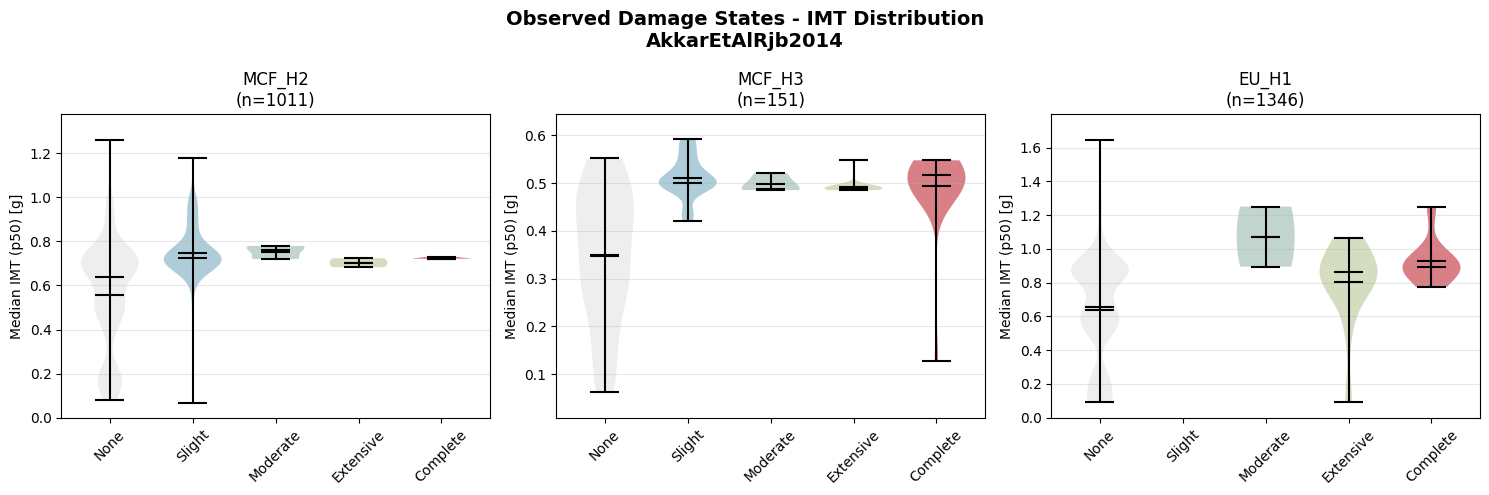

  Creating percentile comparison plots...


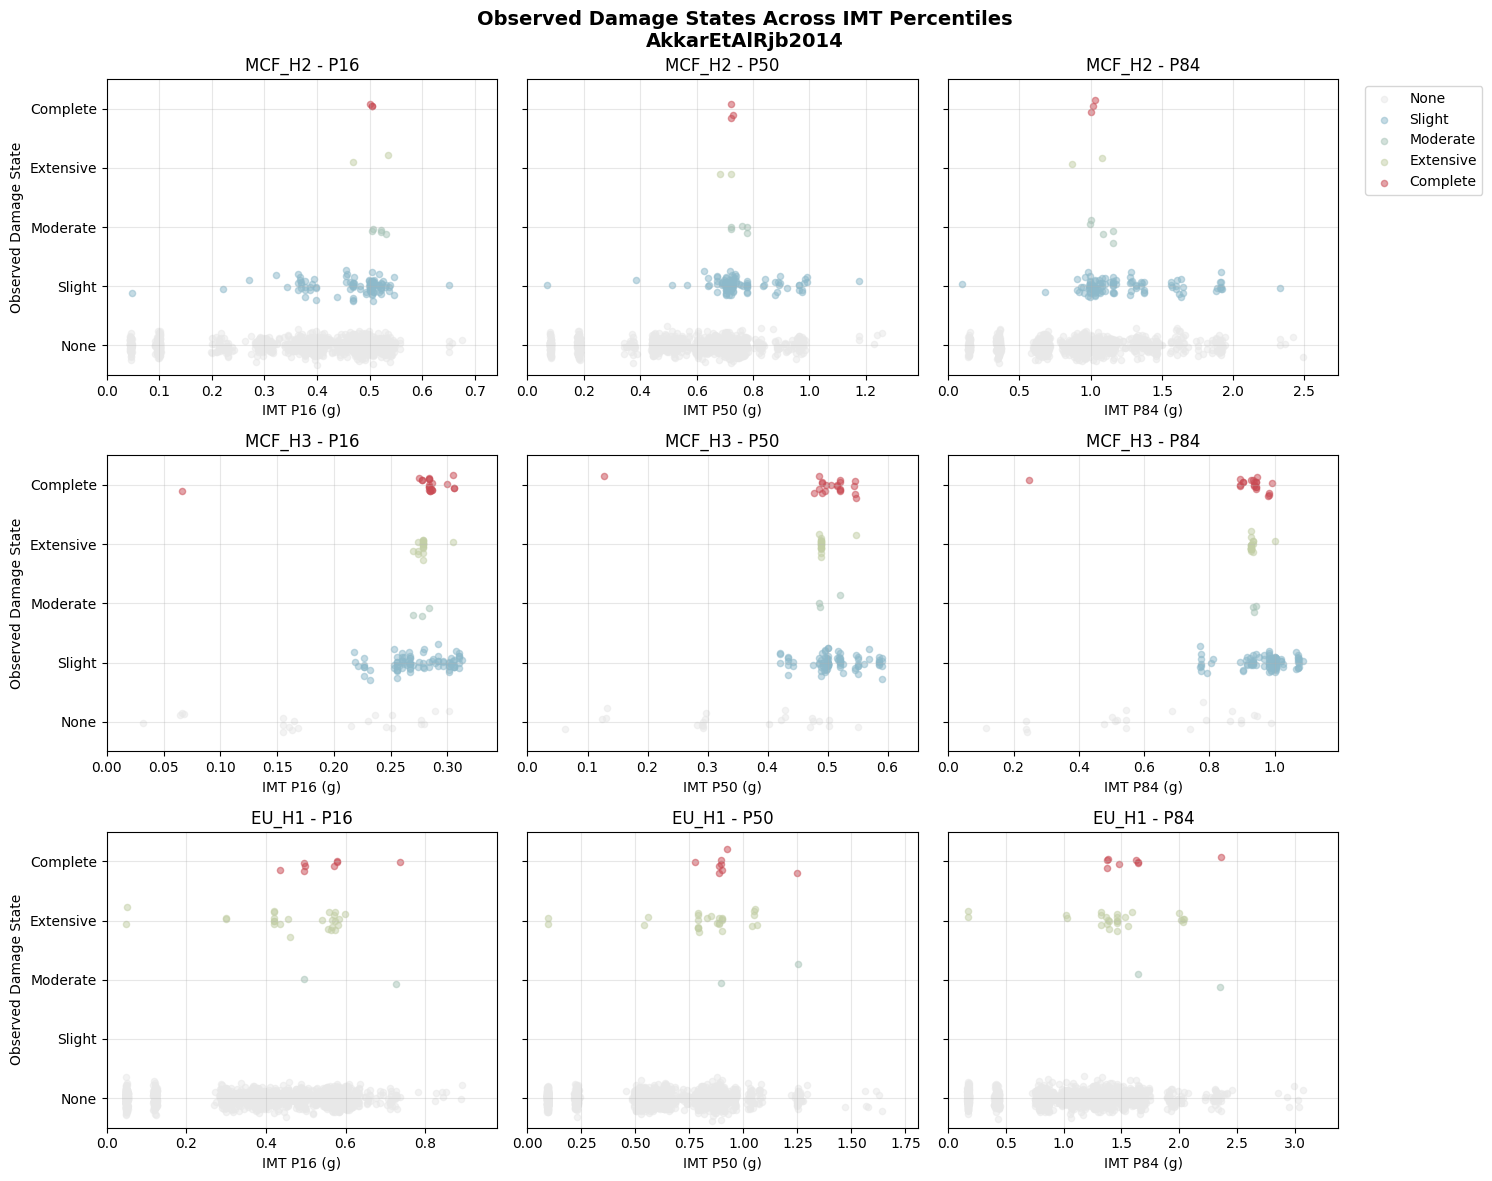

  Generating statistical summary...

AkkarEtAlRjb2014 - Statistical Summary:
------------------------------------------------------------

MCF_H2:
DS         Count    %        Mean_IMT   Std_IMT   
--------------------------------------------------
None       899      88.9     0.556      0.243     
Slight     102      10.1     0.749      0.129     
Moderate   5        0.5      0.752      0.030     
Extensive  2        0.2      0.703      0.029     
Complete   3        0.3      0.724      0.005     

MCF_H3:
DS         Count    %        Mean_IMT   Std_IMT   
--------------------------------------------------
None       22       14.6     0.347      0.142     
Slight     87       57.6     0.511      0.043     
Moderate   3        2.0      0.498      0.020     
Extensive  18       11.9     0.492      0.014     
Complete   21       13.9     0.494      0.087     

EU_H1:
DS         Count    %        Mean_IMT   Std_IMT   
--------------------------------------------------
None       1310     

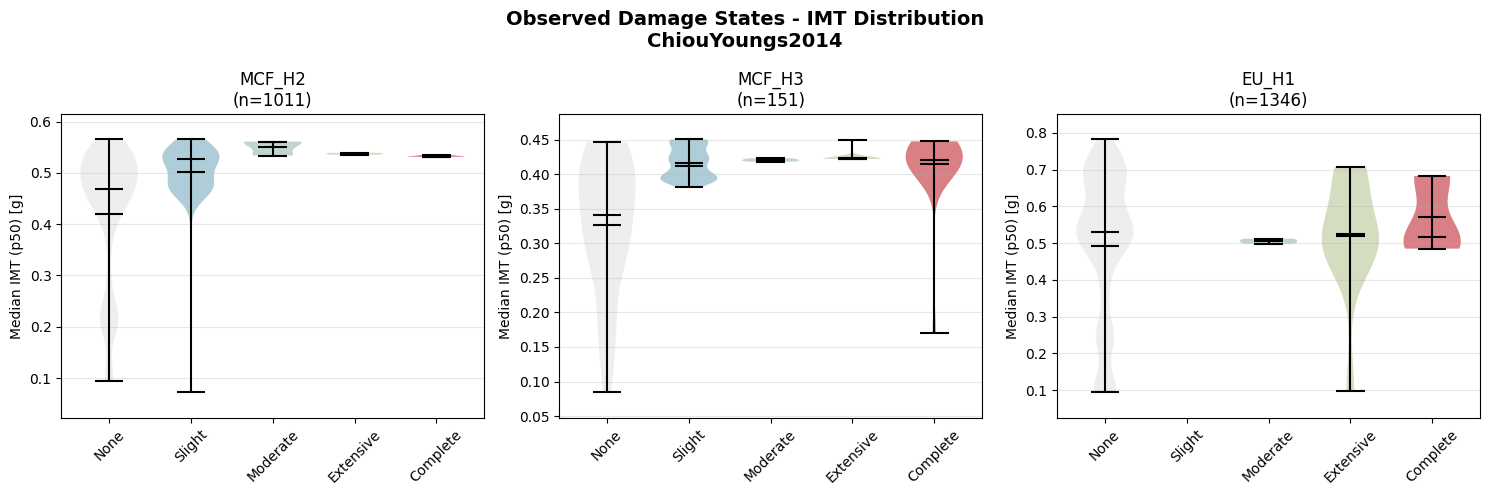

  Creating percentile comparison plots...


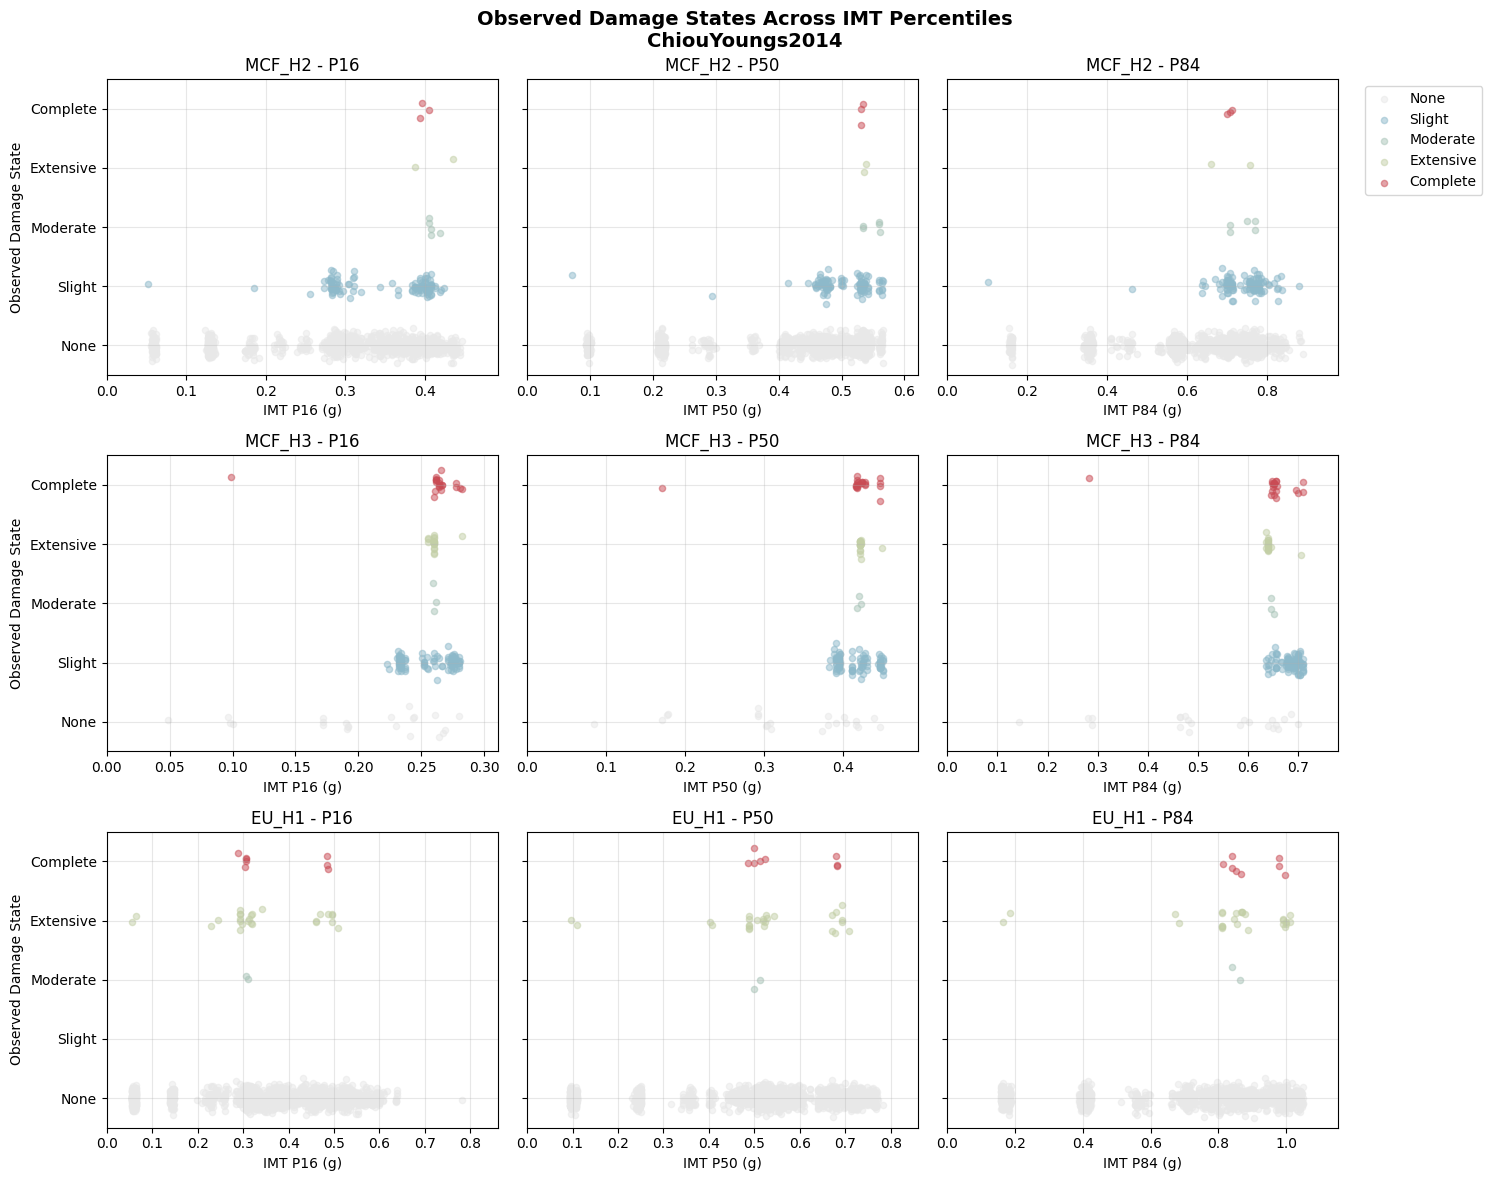

  Generating statistical summary...

ChiouYoungs2014 - Statistical Summary:
------------------------------------------------------------

MCF_H2:
DS         Count    %        Mean_IMT   Std_IMT   
--------------------------------------------------
None       899      88.9     0.421      0.135     
Slight     102      10.1     0.502      0.059     
Moderate   5        0.5      0.550      0.014     
Extensive  2        0.2      0.537      0.003     
Complete   3        0.3      0.533      0.002     

MCF_H3:
DS         Count    %        Mean_IMT   Std_IMT   
--------------------------------------------------
None       22       14.6     0.326      0.100     
Slight     87       57.6     0.417      0.022     
Moderate   3        2.0      0.421      0.002     
Extensive  18       11.9     0.424      0.007     
Complete   21       13.9     0.414      0.057     

EU_H1:
DS         Count    %        Mean_IMT   Std_IMT   
--------------------------------------------------
None       1310     9

In [ ]:
print("\n" + "=" * 70)
print("GENERATING VISUALIZATIONS FOR OBSERVED DAMAGE")
print("=" * 70)

all_summaries = []

for gmpe_model, observed_data in observed_with_gmpe.items():
    print(f"\nProcessing visualizations for {gmpe_model}:")

    # Create violin plots
    print("  Creating violin plots...")
    fig_violin = create_observed_violin_plots(observed_data, gmpe_model)
    plt.show()

    # Create percentile plots
    print("  Creating percentile comparison plots...")
    fig_percentile = create_observed_percentile_plots(observed_data, gmpe_model)
    plt.show()

    # Create statistical summary
    print("  Generating statistical summary...")
    summary_df = create_statistical_summary(observed_data, gmpe_model)
    all_summaries.append(summary_df)

# 6. EXPORT PROCESSED DATA

In [ ]:
print("\n" + "=" * 70)
print("EXPORTING PROCESSED OBSERVED DAMAGE DATA")
print("=" * 70)

# Export main processed data with damage state conversion
export_filename = f'{OUTPUT_FOLDER}observed_damage_processed.csv'
exposure_df.to_csv(export_filename, index=False)
print(f"✓ Exported processed damage data: {export_filename}")
print(f"  Records: {len(exposure_df):,}")
print(f"  Columns: {', '.join(exposure_df.columns)}")

# Export GMPE-merged observed data for each model
for gmpe_model, observed_data in observed_with_gmpe.items():
    export_filename = f'{OUTPUT_FOLDER}observed_damage_with_{gmpe_model}.csv'
    observed_data.to_csv(export_filename, index=False)
    print(f"✓ Exported {gmpe_model} merged data: {export_filename}")
    print(f"  Records: {len(observed_data):,}")

# Export combined summary statistics
if all_summaries:
    combined_summary = pd.concat(all_summaries, ignore_index=True)
    summary_filename = f'{OUTPUT_FOLDER}observed_damage_summary_statistics.csv'
    combined_summary.to_csv(summary_filename, index=False)
    print(f"✓ Exported summary statistics: {summary_filename}")


EXPORTING PROCESSED OBSERVED DAMAGE DATA
✓ Exported processed damage data: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/observed_damage_processed.csv
  Records: 2,508
  Columns: ID, Location, Region, Latitute, Longitude, DG, Material LLRS, LLRS, Height, Date of construction, Occupancy, Structural Irregularity, Roof, parsed_material, parsed_height, parsed_occupancy, building_class, observed_ds
✓ Exported AkkarEtAlRjb2014 merged data: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/observed_damage_with_AkkarEtAlRjb2014.csv
  Records: 2,508
✓ Exported ChiouYoungs2014 merged data: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/observed_damage_with_ChiouYoungs2014.csv
  Records: 2,508
✓ Exported summary statistics: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/observed_damage_summary_statistics.csv


# 7. PREPARE DATA FOR MISFIT ANALYSIS

In [ ]:
print("\n" + "=" * 70)
print("PREPARING DATA FOR DEVIANCE-BASED MISFIT ANALYSIS")
print("=" * 70)

# Create comparison-ready dataset
for gmpe_model, observed_data in observed_with_gmpe.items():
    # Load corresponding analytical predictions
    analytical_filename = f'{OUTPUT_FOLDER}analytical_predictions_{gmpe_model}.csv'

    try:
        analytical_df = pd.read_csv(analytical_filename)
        print(f"\n{gmpe_model}:")
        print(f"  ✓ Loaded analytical predictions: {len(analytical_df):,} records")

        # Merge observed and analytical data
        comparison_df = pd.merge(
            observed_data,
            analytical_df[['id', 'most_probable_ds', 'most_probable_ds_p16',
                          'most_probable_ds_p50', 'most_probable_ds_p84',
                          'p_exceed_slight', 'p_exceed_moderate',
                          'p_exceed_extensive', 'p_exceed_complete']],
            on='id',
            how='inner',
            suffixes=('_obs', '_pred')
        )

        # Export comparison-ready dataset
        comparison_filename = f'{OUTPUT_FOLDER}comparison_ready_{gmpe_model}.csv'
        comparison_df.to_csv(comparison_filename, index=False)
        print(f"  ✓ Exported comparison dataset: {comparison_filename}")
        print(f"    Records: {len(comparison_df):,}")
        print(f"    Ready for deviance-based misfit analysis")

    except FileNotFoundError:
        print(f"  ⚠ Analytical predictions not found for {gmpe_model}")
        print(f"    Run Script 1 first to generate analytical predictions")

print("\n" + "=" * 70)
print("SCRIPT 2 COMPLETED SUCCESSFULLY")
print("=" * 70)
print("\nNext Steps:")
print("1. Review observed damage visualizations")
print("2. Check statistical summaries for damage patterns")
print("3. Use comparison_ready_*.csv files for Script 3 (misfit analysis)")
print("4. Compare observed vs predicted damage state distributions")


PREPARING DATA FOR DEVIANCE-BASED MISFIT ANALYSIS

AkkarEtAlRjb2014:
  ✓ Loaded analytical predictions: 2,508 records
  ✓ Exported comparison dataset: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/comparison_ready_AkkarEtAlRjb2014.csv
    Records: 2,508
    Ready for deviance-based misfit analysis

ChiouYoungs2014:
  ✓ Loaded analytical predictions: 2,508 records
  ✓ Exported comparison dataset: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/comparison_ready_ChiouYoungs2014.csv
    Records: 2,508
    Ready for deviance-based misfit analysis

SCRIPT 2 COMPLETED SUCCESSFULLY

Next Steps:
1. Review observed damage visualizations
2. Check statistical summaries for damage patterns
3. Use comparison_ready_*.csv files for Script 3 (misfit analysis)
4. Compare observed vs predicted damage state distributions
